In [247]:
import tensorsketch as ts
import tqdm
import numpy as np
from Bio import SeqIO
import glob
import matplotlib.pyplot as plt
from numba import njit, prange, cuda, objmode
import pandas as pd

import edlib

In [92]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 3              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 20             #@param {type:"slider",min:10,max:300,step:10}
run_cuda_models = False     #@param {type:"boolean"}
alphabet_size = 4

window = 10000
stride = 5000
normalize = True
sample = ord('m')

common = dict(A=alphabet_size,D=sketch_dim)
tss = ts.TSS(t=tuple_size, S=stride, W=window, **common)

tsm = ts.TSM(t=tuple_size, S=stride, W=window, normalize=normalize,sample=sample,**common)

In [106]:

# Map from sequence characters to internal integer representation.
_char_map: dict[str, int] = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
_char_comp: dict[str, str] = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}


def reverse_complement(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i in range(len(s)):
        char_list[i] = _char_map[_char_comp[s[-i-1]]]
    return char_list

# Given the char_map above, returns an array of length 256 mapping bytes to
# internal integers. -1 signals unknown bytes.

def seq2array(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i,k in enumerate(s):
        char_list[i] = _char_map[k]
    return char_list

data = "/Users/amirjoudaki/Downloads/S_Baltica_new"
files = glob.glob(data + '/*')
print(files)

all_seqs = []
for file in files:
    records = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
    for name,record in records.items():
        seq = dict(file = file, id=record.id, name=record.name, description=record.description)
        seq['seq'] = record.seq
        seq['array'] = seq2array(record.seq)
        seq['rarray'] = seq2array(record.seq)
        all_seqs.append(seq)

all_seqs

['/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS195.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS185.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS625.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_BA175.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS155.new.new.all.fna']


[{'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna',
  'id': 'CP001252.1',
  'name': 'CP001252.1',
  'description': 'CP001252.1 Shewanella baltica OS223 chromosome, complete genome 0',
  'seq': Seq('TTTTTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTG...GCG'),
  'array': array([3, 3, 3, ..., 2, 1, 2], dtype=int8),
  'rarray': array([3, 3, 3, ..., 2, 1, 2], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna',
  'id': 'CP002383.1',
  'name': 'CP002383.1',
  'description': 'CP002383.1 Shewanella baltica OS678, complete genome 0',
  'seq': Seq('TTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTGATG...TAA'),
  'array': array([3, 3, 3, ..., 3, 0, 0], dtype=int8),
  'rarray': array([3, 3, 3, ..., 3, 0, 0], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna',
  'id': 'C_017579.1',
  'name': 'C_017579.1',
  'description': 'C_017579.1 Shewanella baltica OS117, co

In [167]:
%%time
for seq in tqdm.tqdm(all_seqs,total=len(all_seqs)):
    sketch, inds = tsm.sketch(seq['array'])
    # rsketch, rinds = tsm.sketch(seq['rarray'])
    seq['sketch'] = dict(name='tsm',
                         array=sketch,
                         inds=inds,
                         # rarray=rsketch,
                         # rinds=rinds
                         )

  0%|          | 0/8 [00:10<?, ?it/s]


SystemError: CPUDispatcher(<function method at 0x7fd9d3ab2040>) returned a result with an error set

In [233]:
s1, s2 = 1, 5
seq1, seq2 = all_seqs[s1]['seq'],all_seqs[s2]['seq']
sk1, sk2 = all_seqs[s1]['sketch']['array'], all_seqs[s2]['sketch']['array']
sk1 = sk1.transpose() / np.sqrt(np.nansum(sk1**2,axis=1))
sk2 = sk2.transpose() / np.sqrt(np.nansum(sk2**2,axis=1))
prod = np.matmul(sk1.transpose(),sk2)
dists = np.array([(i,j,1-prod[i,j]) for i in range(prod.shape[0]) for j in range(prod.shape[1])])
idx = np.argsort(dists[:,2])
dists = dists[idx,:]

In [234]:
num_samples = 200
uniform_dists = np.random.random(num_samples)**4 / 2
uniform_indices = np.searchsorted(dists[:,2],uniform_dists)
uniform_indices = list(range(num_samples))
df = pd.DataFrame(columns=['s1','s2','i1','i2','j1','j2','d','ed','ed_norm','ed2','ed_norm2'])
for index in tqdm.tqdm(uniform_indices):
    i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]
    idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
    query, target = seq1[idx1-window:idx1],seq2[idx2-window:idx2]
    result = edlib.align(query,target,task='path')
    if not result['cigar']:
        continue
    nice = edlib.getNiceAlignment(result, query, target)
    first = nice['matched_aligned'].find('|'*15)
    query_aligned = nice['query_aligned'][:first]
    target_aligned = nice['target_aligned'][:first]
    d1, d2 = query_aligned.count('-'), target_aligned.count('-')
    L = window - max(d1,d2)
    result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
    ed, ed_norm = result['editDistance'], result['editDistance']/window
    ed2, ed_norm2 = result2['e ditDistance'],result2['editDistance']/L

    # print("\n".join([str(v) for k,v in nice.items()]))
    df.loc[len(df),:] = (s1,s2,idx1-window,idx1,idx2-window,idx2,d,ed,ed_norm,ed2, ed_norm2)
df

100%|██████████| 200/200 [00:06<00:00, 31.61it/s]


,s1,s2,i1,i2,j1,j2,d,ed,ed_norm,ed2,ed_norm2
0,1,5,4114436,4124436,4525753,4535753,-0.0,0,0.0,0,0.0
1,1,5,4571716,4581716,4981941,4991941,-0.0,0,0.0,0,0.0
2,1,5,2181157,2191157,1554839,1564839,-0.0,0,0.0,0,0.0
3,1,5,704089,714089,142505,152505,-0.0,0,0.0,0,0.0
4,1,5,5039126,5049126,4018660,4028660,-0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
195,1,5,3675407,3685407,2971795,2981795,0.000003,23,0.0023,23,0.0023
196,1,5,4932476,4942476,3915595,3925595,0.000003,62,0.0062,62,0.0062
197,1,5,4594880,4604880,5004998,5014998,0.000004,214,0.0214,0,0.0
198,1,5,1527730,1537730,3290000,3300000,0.000004,20,0.002,2,0.0002


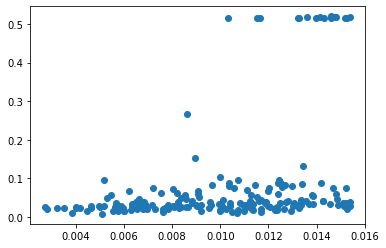

In [191]:
plt.scatter([np.arccos(1-v) for v in df.d.values], df.ed_norm2)

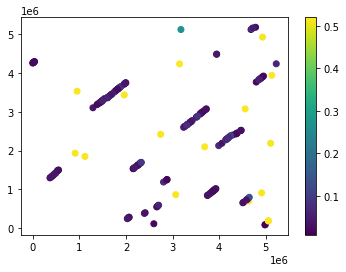

In [193]:
plt.scatter(df.i1, df.j1, c=df.ed_norm2)
plt.colorbar()

In [235]:
index = 200
i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]

d = np.linalg.norm(sk1[:,i]- sk2[:,j])
idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
S1, S2 = seq1[idx1-window:idx1],seq2[idx2-window:idx2]
query, target = S1,S2
result = edlib.align(query,target,task='path')
nice = edlib.getNiceAlignment(result, query, target)
first = nice['matched_aligned'].find('|'*15)
query_aligned = nice['query_aligned']
target_aligned = nice['target_aligned']
d1, d2 = query_aligned[:first].count('-'), target_aligned[:first].count('-')
L = window - max(d1,d2)
result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
ed, ed_norm = result2['editDistance'],result2['editDistance']/L
indels = query_aligned[first:first+L].count("-")/L
print(f'{i}, {j}, {idx1}, {idx2} {d:.5f}, {ed_norm:.3f}, {indels:.3f}')


59, 265, 295238, 1325570 0.00275, 0.002, 0.000


/var/folders/f_/k4t2qy550m59jflz950fy7z40000gn/T/ipykernel_47899/1549250306.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  match = [np.mean(np.array(target[i:])!=np.array(query[:-i])) for i in range(-100,100)]


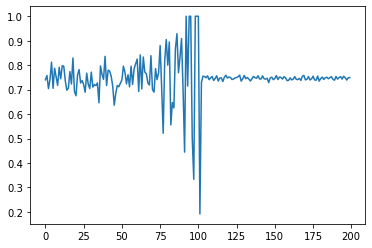

In [246]:
match = [np.mean(np.array(target[i:])!=np.array(query[:-i])) for i in range(-100,100)]
plt.plot(match)

In [200]:
# I = int(3e6)
# L = int(10e3)
query = S1
target = seq2
result = edlib.align(query, target, mode='HW',task='path')
nice = edlib.getNiceAlignment(result, query, target)
print('locations = ', result['locations'])
print('match score = ',nice['matched_aligned'].count('|')/len(query))
nice['matched_aligned']

locations =  [(2708481, 2718456), (2708481, 2718457), (2708481, 2718458), (2708481, 2718459)]
match score =  0.9382


'||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||.||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [232]:
str(nice['target_aligned']).count('-')/len(nice['target_aligned'])

0.01364445323314218

In [231]:
[query.count(c) for c in 'ACGT'],[target.count(c) for c in 'ACGT']

([2629, 2375, 2323, 2673], [1407497, 1216512, 1186955, 1384275])

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

N = len(all_seqs)

for i in range(N):
    for j in range(i,N):
        sk1 = all_seqs[i]['sketch']['array']
        sk2 = all_seqs[j]['sketch']['array']
        sk1 = sk1.transpose() / np.sqrt(np.sum(sk1**2,axis=1))
        sk2 = sk2.transpose() / np.sqrt(np.sum(sk2**2,axis=1))
        prod = np.matmul(sk1.transpose(),sk2)
        angle = np.arccos(prod) / np.pi

        plt.matshow(angle)
        plt.colorbar()
        plt.title(f'seq {i} vs. seq {j}')
        plt.show()

In [201]:
M = np.random.randn(sketch_dim,sketch_dim)
sk1_proj = ((M @ sk1) > 0).astype(np.int32)
sk2_proj = ((M @ sk2) > 0).astype(np.int32)
np.intersect1d(sk1_proj,)

(20, 1105)

In [230]:
sk1_proj

(40, 1105)

In [227]:
sk1_proj.shape, sk1.shape

((20, 1105), (20, 1105))